<a href="https://colab.research.google.com/github/marienbaptiste/IBM-Capstone/blob/master/Capstone_Project_The_Battle_of_Neighborhoods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

**Background** - As a product owner moving to San Francisco on early 2020, I have at heart to find a safe location for myself and my family.


**Business Problem** - This led to a sort of cheek in tongue idea: how about finding the correlation between criminality and what we could get out of Foursquare, a service absolutely not designed to return geopolitical and societal insights. This would serve multiple purposes:


*Primary*

*   Getting to know the type of neighborhood with a glance at the venues in the streets.


*Secondary*

*   Shouldering the idea that information is not data but what we get out of it.

*   The difference between correlation and causation in action.

*   Working with nonoptimal/indirectly correlated data for a case, as most real-life projects.

*   Showing the importance of ethics and a way fake news could be born.


## Data <a name="data"></a>

**To complete this task and validate our assumptions, we will use:**



*   The **venues database in Foursquare** (2019 data) [[Source](https://developer.foursquare.com/) | [Documentation](https://developer.foursquare.com/docs)]

*   The **Census Tract boundaries** (2010 data) as one of our data, Average Income per Household is per census tract [[Source](https://www.census.gov/) | [File](https://github.com/marienbaptiste/IBM-Capstone/blob/master/RSX/2010_san_francisco_census_tracts.geojson)], this is a cleanup of what could be found on the geo.census.gov website

*   The **Average Income per Household** (2013-2017) [[Source](https://datausa.io/profile/geo/san-francisco-ca) | [File](https://github.com/marienbaptiste/IBM-Capstone/blob/master/RSX/Income%20by%20Location.csv)]

*   The **Crime report CSV file** (2016) provided by IDM
[[File](https://cocl.us/sanfran_crime_dataset)]

*   The **Geolocation tool** provided by the Census Bureau will come handy [[Tool](https://geocoding.geo.census.gov/geocoder) | [Documentation](https://geocoding.geo.census.gov/geocoder/Geocoding_Services_API.pdf)]


All of this to correlate crimes with a type of venue and plot it all on the map.
Then we might want to find an inverse correlation with another type of venue.
Finally we will compare it to a first hand correlation with crimes, namely a poverty index (https://en.wikipedia.org/wiki/Statistical_correlations_of_criminal_behaviour) under the form of the Average Income per Household.


###Libraries


In [1]:
import numpy as np  # useful for many scientific computing in Python
import pandas as pd # primary data structure library
import folium 
from folium.plugins import MarkerCluster
!pip install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

###Finding the default location for San Francisco

In [2]:
# Let's get the geographical coordinates of San Francisco using Geopy
address = 'San Francisco'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of San Francisco are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of San Francisco are 37.7792808, -122.4192363.


###Importing the 2016 crimes report for San Francisco

In [3]:
# Simple csv to dataframe import
df_incidents = pd.read_csv('https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DV0101EN/labs/Data_Files/Police_Department_Incidents_-_Previous_Year__2016_.csv')

print('Dataset downloaded and read into a pandas dataframe!')

Dataset downloaded and read into a pandas dataframe!


In [4]:
df_incidents.shape # 150k incidents! That calls for some trimming and grouping

(150500, 13)

###Finding all categories of crimes

In [5]:
# Some of those don't fall into the definition of a directly dangerous neighbourhood
type(df_incidents)
df_ucats=df_incidents['Category'].unique()
df_ucats

array(['WEAPON LAWS', 'WARRANTS', 'NON-CRIMINAL', 'ASSAULT',
       'OTHER OFFENSES', 'MISSING PERSON', 'LARCENY/THEFT', 'BURGLARY',
       'STOLEN PROPERTY', 'ROBBERY', 'FRAUD', 'DRUG/NARCOTIC',
       'VEHICLE THEFT', 'RECOVERED VEHICLE', 'VANDALISM', 'ARSON',
       'PROSTITUTION', 'SECONDARY CODES', 'SUSPICIOUS OCC', 'DRUNKENNESS',
       'TRESPASS', 'SEX OFFENSES, NON FORCIBLE', 'SEX OFFENSES, FORCIBLE',
       'RUNAWAY', 'KIDNAPPING', 'DISORDERLY CONDUCT',
       'DRIVING UNDER THE INFLUENCE', 'FORGERY/COUNTERFEITING',
       'EMBEZZLEMENT', 'BRIBERY', 'FAMILY OFFENSES', 'GAMBLING',
       'SUICIDE', 'LIQUOR LAWS', 'EXTORTION', 'LOITERING', 'TREA',
       'BAD CHECKS', 'PORNOGRAPHY/OBSCENE MAT'], dtype=object)

###Let's remove the crimes that wouldn't be a direct threat in the street

In [6]:
# This depends on everyone's definition of a violent crime or environmental degradation, we are removing the following
incident_filter = ['WEAPON LAWS',
                   'WARRANTS',
                   'NON-CRIMINAL',
                   'MISSING PERSON',
                   'FRAUD',
                   'RECOVERED VEHICLE',
                   'SECONDARY CODES',
                   'RUNAWAY',
                   'FORGERY/COUNTERFEITING',
                   'EMBEZZLEMENT',
                   'BRIBERY',
                   'FAMILY OFFENSES',
                   'GAMBLING',
                   'SUICIDE',
                   'BAD CHECKS',
                   'PORNOGRAPHY/OBSCENE MAT']

# Fancy operator to capture all but the above listed categories
df_incidents = df_incidents[~df_incidents['Category'].isin(incident_filter)]

df_incidents.shape # 114k, a bit better but still not the safest city in the world...

(114339, 13)

###And now we are removing the useless columns for our purpose

In [0]:
df_incidents.drop(['IncidntNum', 'Descript', 'DayOfWeek', 'Date', 'Time','PdDistrict', 'Resolution', 'Address', 'Location', 'PdId'], axis=1, inplace=True)

In [8]:
# All cleaned-up!
df_incidents.head()

,Category,X,Y
5,ASSAULT,-122.426077,37.788019
6,OTHER OFFENSES,-122.405721,37.780879
10,LARCENY/THEFT,-122.477377,37.764478
12,OTHER OFFENSES,-122.376758,37.735697
13,ASSAULT,-122.432326,37.729271


###Plotting a few incident to check if it all goes well

In [9]:
# Getting the 100 first incidents
limit = 100
df_incidents_limit = df_incidents.iloc[0:limit, :]
df_incidents_limit.shape

(100, 3)

In [0]:
# Create a map of San Francisco using latitude and longitude values
sanfran_map = folium.Map(location=[latitude, longitude], zoom_start=12)

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in zip(df_incidents_limit.Y, df_incidents_limit.X):
    sanfran_map.add_child(
        folium.vector_layers.CircleMarker(
            [lat, lng],
            radius=5, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )
    
sanfran_map

Picture for reference as Github won't display maps
![Thumbnail of a the San Francisco map](https://raw.githubusercontent.com/marienbaptiste/IBM-Capstone/master/RSX/sf1.png)

###Neighbordhood grouping

We are in dire need for a way to attribute every single incident to a census block. Here comes the API provided by the US governement

In [0]:
import json
import requests

lat_test = 37.775421
long_test = -122.403405

#Test Api
geocensus_url='https://geocoding.geo.census.gov/geocoder/geographies/coordinates?x={0}&y={1}&benchmark=9&vintage=910&format=json'.format(long_test, lat_test)
js_api = json.loads(requests.get(geocensus_url).text)

Awesome! It works, let's hammer a .gov URL with 114k requests!
... Actually, let's not, that a really bad idea.
After some research, a nifty point to polygon collision has been found. The execution will be local and **will save us from being IP banned**

###Building a custom class and function to consume our library

In [0]:
# That magic library
from shapely.geometry import shape, Point

# Returned object
class PointAsCensus:
  Found = False #True if a matching block has been found
  GeoID = None #Default GeoID
  Name = None #Default friendly name
  def __init__(self, found, geoid, name):
    self.Found = found
    self.GeoID = geoid
    self.Name = name

# Function to return a Census Tract ID if found in San Francisco
def coord_to_sf_census_block(Json_as_text, X, Y):
  # construct point based on lon/lat
  point = Point(X, Y) 
  # check each polygon to see if it contains the point
  for feature in Json_as_text['features']:
    polygon = shape(feature['geometry'])
    if polygon.contains(point):
        return (PointAsCensus(True,feature['properties']['GEOID10'],feature['properties']['NAMELSAD10']))
        break
  return (PointAsCensus(False, None, None))

In [13]:
# A quick test run with the San Francisco coordinates
js_census = json.loads(requests.get('https://raw.githubusercontent.com/marienbaptiste/IBM-Capstone/master/RSX/2010_san_francisco_census_tracts.geojson').text)

area = coord_to_sf_census_block(js_census, long_test, lat_test)
print(area.Name) # It works and it is reliable!

Census Tract 180


In [14]:
# Comparing to the reference API...
print ('The same value has been found with the API') if str(js_api).find(area.Name)!=-1 else ('The API found a different value')


The same value has been found with the API


###Batch processing

This bit of code is **VERY processing intensive**, it takes a serious amount of time (~3mins) to process. Also, our Kernel seems to crash hwhen processing more than 5000 inputs at a time. The solution found is to:


1.   Split our processing into batches, we can also witness the progress this way
2.   Save the result once processed in a pkl file (which preserves the data types)
3.   Reuse the saved file on subsequent runs to save a massive amount of time

All of that is controlled by the widget following


In [0]:
#@title Crimes Set Options { vertical-output: true, display-mode: "form" }
generate_crimes_file = False #@param {type:"boolean"}

In [16]:
# This bit mounts a Google Drive, asking for credentials 
from google.colab import drive
drive.mount('drive')
df_incidents_census = pd.DataFrame() # Initializing our result object

# Boolean switch to force generate or use stored file on Drive
if generate_crimes_file:
  # Attributing census block ID from scratch
  print("generating file...")
  import sys

  i=0
  chunks=100 # Size of our chunks, 100 seems like a good balance between feedback, speed and reliability
  for item in np.array_split(df_incidents, chunks):
      i +=  1
      sys.stdout.write('\rProgress: {:.0f}% '.format(i*chunks/100)) # Primitive progress indicator
      item['Census'] = item.apply(lambda row: coord_to_sf_census_block(js_census, row['X'], row['Y']).GeoID, axis=1) # Lambda expression to update every row with its matching census block ID
      df_incidents_census=df_incidents_census.append(item)
  
  df_incidents_census.to_pickle('sf_crimes.pkl') # Save as a pickle file, smaller than csv, typed, but bad for debugging as the payload is compressed
  !cp sf_crimes.pkl drive/My\ Drive/Colab\ Notebooks/Data
  print("file generated!")
else:
  #Reusing formerly saved file (this saves roughly 3mins)
  print("using local file...")
  path = "/content/drive/My Drive/Colab Notebooks/Data/sf_crimes.pkl"
  df_incidents_census = pd.read_pickle(path)

  print("file loaded...")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at drive
using local file...
file loaded...


In [17]:
df_incidents_census.shape # Verifying that the amount of rows has been preserved

(114339, 4)

In [18]:
df_incidents_census.head() # Nice, the column has been added and Census is populated, we are now able to attribute each incident to a Census Block and group them

,Category,X,Y,Census
5,ASSAULT,-122.426077,37.788019,06075015200
6,OTHER OFFENSES,-122.405721,37.780879,06075017601
10,LARCENY/THEFT,-122.477377,37.764478,06075032601
12,OTHER OFFENSES,-122.376758,37.735697,06075023103
13,ASSAULT,-122.432326,37.729271,06075025500


###Cleaning up the data

In [19]:
# Check if missing value
print ('This dataframe is missing {0} area values'.format(df_incidents_census['Census'].isnull().sum()))

This dataframe is missing 193 area values


In [20]:
df_miss=df_incidents_census[df_incidents_census['Census'].isnull()]
df_miss.head() # Ouch... Some Incidents can't be attributed to a census block. We need to plot that to understand what is happening

,Category,X,Y,Census
435,OTHER OFFENSES,-122.365565,37.809671,None
925,TRESPASS,-122.365565,37.809671,None
2457,ARSON,-122.365565,37.809671,None
3188,BURGLARY,-122.365565,37.809671,None
3829,LARCENY/THEFT,-122.365565,37.809671,None


In [0]:
#Create a map of San Francisco using latitude and longitude values
sanfran_map = folium.Map(location=[latitude, longitude], zoom_start=12, tiles='Stamen Toner')

#Add markers to map
for lat, lng, in zip(df_miss.Y, df_miss.X):
    sanfran_map.add_child(
        folium.vector_layers.CircleMarker(
            [lat, lng],
            radius=5, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='black',
            fill_opacity=0.6
        )
    )
    
sanfran_map

Picture for reference as Github won't display maps
![Thumbnail of a the San Francisco map](https://raw.githubusercontent.com/marienbaptiste/IBM-Capstone/master/RSX/sf2.png)

It appears that those values are on the borders, so we can get rid off then!
The simple translation is that **our definition of San Francisco does not match perfectly what the police report defines as San Francisco**. No real problem since we are working on the census blocks definition. Information bleading out of our scope is actually a good thing and confirms that we won't have partial values for the border blocks.

In [0]:
# Remorseless deletion
df_incidents_census.dropna(inplace=True)
df_incidents_census.reset_index(drop=True, inplace=True)

###Create dummies from categories

In [23]:
# Creating dummies just for good practice, in case we are finding oddities
df_incidents_census = pd.concat([df_incidents_census, pd.get_dummies(df_incidents_census['Category'])], axis=1)
df_incidents_census.head()

,Category,X,Y,Census,ARSON,ASSAULT,BURGLARY,DISORDERLY CONDUCT,DRIVING UNDER THE INFLUENCE,DRUG/NARCOTIC,DRUNKENNESS,EXTORTION,KIDNAPPING,LARCENY/THEFT,LIQUOR LAWS,LOITERING,OTHER OFFENSES,PROSTITUTION,ROBBERY,"SEX OFFENSES, FORCIBLE","SEX OFFENSES, NON FORCIBLE",STOLEN PROPERTY,SUSPICIOUS OCC,TREA,TRESPASS,VANDALISM,VEHICLE THEFT
0,ASSAULT,-122.426077,37.788019,06075015200,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,OTHER OFFENSES,-122.405721,37.780879,06075017601,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,LARCENY/THEFT,-122.477377,37.764478,06075032601,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,OTHER OFFENSES,-122.376758,37.735697,06075023103,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,ASSAULT,-122.432326,37.729271,06075025500,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


###Grouping

In [0]:
# Proceed to aggregate neighbourhood sharing Census

# Remove the useless Coords
df_incidents_grouped = df_incidents_census.drop(columns=['X', 'Y'])

# Aggregate and sum
df_incidents_grouped = df_incidents_grouped.groupby(['Census'], sort=True).sum()
df_incidents_grouped.columns = map(str.capitalize, df_incidents_grouped.columns) #OCD renaming
df_incidents_grouped.reset_index(inplace=True) #Reset the index to 0

# Adding and extra column for the sum of incidents, excluding the Census from the sum is not necessary as it is an object and therefore skipped, but just for the sake of it, let's filter it out 
col_list = df_incidents_grouped.columns.drop('Census') #All columns except Census
df_incidents_grouped['Crimes'] = df_incidents_grouped[col_list].sum(axis=1) #Generating a total column
col_list = df_incidents_grouped.columns.drop('Census') #Update
#df_incidents_grouped[col_list] = df_incidents_grouped[col_list].astype(int) #Fixing the casting to float when making the sum

In [25]:
df_incidents_grouped.shape # Thats a lot smaller!

(194, 25)

In [26]:
df_incidents_grouped.head()

,Census,Arson,Assault,Burglary,Disorderly conduct,Driving under the influence,Drug/narcotic,Drunkenness,Extortion,Kidnapping,Larceny/theft,Liquor laws,Loitering,Other offenses,Prostitution,Robbery,"Sex offenses, forcible","Sex offenses, non forcible",Stolen property,Suspicious occ,Trea,Trespass,Vandalism,Vehicle theft,Crimes
0,06075010100,2.0,157.0,67.0,4.0,3.0,29.0,4.0,0.0,0.0,1596.0,5.0,2.0,235.0,0.0,43.0,4.0,0.0,34.0,70.0,0.0,16.0,209.0,47.0,2527.0
1,06075010200,1.0,53.0,42.0,0.0,5.0,9.0,0.0,0.0,5.0,781.0,1.0,0.0,94.0,0.0,18.0,6.0,0.0,12.0,28.0,0.0,8.0,87.0,34.0,1184.0
2,06075010300,0.0,21.0,20.0,0.0,1.0,5.0,1.0,0.0,0.0,197.0,0.0,0.0,70.0,0.0,11.0,4.0,0.0,9.0,20.0,0.0,4.0,40.0,25.0,428.0
3,06075010400,1.0,23.0,23.0,1.0,0.0,4.0,2.0,0.0,0.0,179.0,0.0,1.0,50.0,0.0,8.0,2.0,0.0,0.0,18.0,0.0,5.0,50.0,27.0,394.0
4,06075010500,2.0,89.0,75.0,5.0,1.0,16.0,7.0,0.0,1.0,740.0,1.0,0.0,164.0,0.0,24.0,8.0,0.0,27.0,48.0,0.0,24.0,104.0,37.0,1373.0


###Merging the Average Income per Household value to serve as a test sample (2013-2017)

In [27]:
df_incomes = pd.read_csv('https://raw.githubusercontent.com/marienbaptiste/IBM-Capstone/master/RSX/Income%20by%20Location.csv')

print('Dataset downloaded and read into a pandas dataframe!')

Dataset downloaded and read into a pandas dataframe!


In [28]:
df_incomes.shape

(973, 8)

In [29]:
df_incomes.head()

,ID Year,Year,ID Race,Race,Household Income by Race,Household Income by Race Moe,Geography,ID Geography
0,2017,2017,0,Total,153912,19961.0,"Census Tract 207, San Francisco County, CA",14000US06075020700
1,2017,2017,0,Total,103750,79349.0,"Census Tract 9809, San Francisco County, CA",14000US06075980900
2,2017,2017,0,Total,98023,21136.0,"Census Tract 329.01, San Francisco County, CA",14000US06075032901
3,2017,2017,0,Total,81509,19512.0,"Census Tract 101, San Francisco County, CA",14000US06075010100
4,2017,2017,0,Total,93613,7363.0,"Census Tract 329.02, San Francisco County, CA",14000US06075032902


In [0]:
# Keeping only the relevant columns
df_incomes = df_incomes[['Year', 'Household Income by Race', 'ID Geography']]

In [0]:
# Since race value is set to Total, we can rename income column
df_incomes.columns = ['Year','Income','Census']

# Keeping the latest found value per ID Geography
df_incomes = df_incomes.groupby('Census').max(level='Year')
df_incomes.reset_index(inplace=True) 

# Remove the 7 leading characters in the Census column
df_incomes['Census'] = df_incomes['Census'].map(lambda x: x[7:])

In [32]:
df_incomes.head() # Nice, this is now very easy to merge to our Crimes dataframe

,Census,Year,Income
0,06075010100,2017,81509
1,06075010200,2017,125238
2,06075010300,2017,118210
3,06075010400,2017,106979
4,06075010500,2017,119750


In [33]:
df_incomes.shape

(195, 3)

###Joining the Average Household Income to the Crimes dataframe

In [34]:
# Join to the master Dataframe
df_incidents_grouped = df_incidents_grouped.set_index('Census').join(df_incomes[['Census', 'Income']].set_index('Census'))
# Reset the index to 0
df_incidents_grouped.reset_index(inplace=True) 

df_incidents_grouped.head()

,Census,Arson,Assault,Burglary,Disorderly conduct,Driving under the influence,Drug/narcotic,Drunkenness,Extortion,Kidnapping,Larceny/theft,Liquor laws,Loitering,Other offenses,Prostitution,Robbery,"Sex offenses, forcible","Sex offenses, non forcible",Stolen property,Suspicious occ,Trea,Trespass,Vandalism,Vehicle theft,Crimes,Income
0,06075010100,2.0,157.0,67.0,4.0,3.0,29.0,4.0,0.0,0.0,1596.0,5.0,2.0,235.0,0.0,43.0,4.0,0.0,34.0,70.0,0.0,16.0,209.0,47.0,2527.0,81509
1,06075010200,1.0,53.0,42.0,0.0,5.0,9.0,0.0,0.0,5.0,781.0,1.0,0.0,94.0,0.0,18.0,6.0,0.0,12.0,28.0,0.0,8.0,87.0,34.0,1184.0,125238
2,06075010300,0.0,21.0,20.0,0.0,1.0,5.0,1.0,0.0,0.0,197.0,0.0,0.0,70.0,0.0,11.0,4.0,0.0,9.0,20.0,0.0,4.0,40.0,25.0,428.0,118210
3,06075010400,1.0,23.0,23.0,1.0,0.0,4.0,2.0,0.0,0.0,179.0,0.0,1.0,50.0,0.0,8.0,2.0,0.0,0.0,18.0,0.0,5.0,50.0,27.0,394.0,106979
4,06075010500,2.0,89.0,75.0,5.0,1.0,16.0,7.0,0.0,1.0,740.0,1.0,0.0,164.0,0.0,24.0,8.0,0.0,27.0,48.0,0.0,24.0,104.0,37.0,1373.0,119750


###Foursquare Time!

In [35]:
from getpass import getpass # to hide secret key
import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

CLIENT_ID = 'SR4IUUCSUAPSQMPHRMJMFL4E3K1PZNNJGGTAMKCANJ1V4XSY' # your Foursquare ID
CLIENT_SECRET = getpass('Enter the client secret value: ') # your Foursquare Secret
VERSION = '20180605' # foursquare API version
LIMIT = 100 # limit of number of venues returned by Foursquare API

# reference: https://developer.foursquare.com/docs/resources/categories
VENUES_CATS ={'Fastfood': '4bf58dd8d48988d16e941735',
                'Yoga': '4bf58dd8d48988d102941735'} # venue ID for fastfood restaurants and yoga studios

Enter the client secret value: ··········


We now want to to get the list of all Fastfood restaurants and Yoga studios in San Francisco.
Our issue is that the Foursquare API returns a max of 100 venues per request.
Getting all the venues requires us to cover the city with overlapping discs.

The proper solution involves an algorithm such as [Circle Packing ](https://en.wikipedia.org/wiki/Circle_packing) with increased radius to cover all the map. This is overkill for that one project and we will use [this tool](https://www.mapdevelopers.com/draw-circle-tool.php) and a few tests to estimate the position and radius of each disc.

In [0]:
#https://www.mapdevelopers.com/draw-circle-tool.php?circles=%5B%5B6228.93%2C37.7572783%2C-122.4861656%2C%22%23AAAAAA%22%2C%22%23000000%22%2C0.4%5D%2C%5B3264%2C37.7953196%2C-122.425949%2C%22%23AAAAAA%22%2C%22%23000000%22%2C0.4%5D%2C%5B3653.2%2C37.7603086%2C-122.3809733%2C%22%23AAAAAA%22%2C%22%23000000%22%2C0.4%5D%2C%5B3653.2%2C37.7236606%2C-122.3940199%2C%22%23AAAAAA%22%2C%22%23000000%22%2C0.4%5D%5D
# Let's build a dataframe based on our estimation
api_coverage = pd.DataFrame(data={'lats': [37.757278, 37.760309, 37.723661, 37.807020, 37.802952, 37.785822, 37.711442],
                'lons': [-122.486166, -122.380973, -122.394020, -122.433826, -122.395718, -122.418054, -122.438632],
                'radius': [6200, 3700, 3700, 2100, 1820, 1515, 1500]})

In [0]:
# create a map of crimes per census tract block
sanfran_map = folium.Map(location=[latitude, longitude], zoom_start=12)

#Crime ranges
threshold_scale = np.linspace(df_incidents_grouped['Crimes'].min(),
                              df_incidents_grouped['Crimes'].max(),
                              7, dtype=int)

threshold_scale = threshold_scale.tolist() # change the numpy array to a list
threshold_scale[-1] = threshold_scale[-1] + 1 # make sure that the last value of the list is greater than the maximum

# generate choropleth map
sanfran_map.choropleth(
    geo_data=js_census,
    data=df_incidents_grouped,
    columns=['Census', 'Crimes'],
    key_on='feature.properties.GEOID10',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    threshold_scale = threshold_scale,
    legend_name='Crimes per Census Tract in San Francisco'
)

# We can verify visually if the surface of the census tract blocks is all covered
feature_group = folium.FeatureGroup(name='API centroids')

for i in range(0,len(api_coverage)):
    feature_group.add_child(folium.Circle([float(api_coverage['lats'][i]), float(api_coverage['lons'][i])],
            popup= 'API call #{0}'.format(str(i)),
            radius=int(api_coverage['radius'][i]),
            color='black',
            fill=True,
            fill_color='black',
            )).add_to(sanfran_map)

# display map
sanfran_map

Picture for reference as Github won't display maps
![Thumbnail of a the San Francisco map](https://raw.githubusercontent.com/marienbaptiste/IBM-Capstone/master/RSX/sf3.png)

Now that we have a spacial distribution for our queries, we just have to **run the requests**, **append the data** and **get rid of the duplicates** from the overlapping areas

1.   Loop through data
2.   Save the result once processed in a pkl file (which preserves the data types)
3.   Reuse the saved file on subsequent runs to save API usage

All of that is controlled by the widget following

In [0]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [0]:
# function extract all venues in a compound area for a category 
def get_venues(categoryname):
  # init
  df_venues = pd.DataFrame()

  for i in range(0,len(api_coverage)):
  #for i in range(0,1):
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION,
    api_coverage['lats'][i], 
    api_coverage['lons'][i], 
    api_coverage['radius'][i],
    VENUES_CATS[categoryname],
    LIMIT)

    #Fetching, careful with daily limit
    results = requests.get(url).json()

    venues = results['response']['groups'][0]['items']
    
    nearby_venues = json_normalize(venues) # flatten JSON

    # filter columns
    filtered_columns = ['venue.id', 'venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
    nearby_venues = nearby_venues.loc[:, filtered_columns]

    # filter the category for each row
    nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

    # clean columns
    nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

    # hard coded category in case our target comes under different denominations
    nearby_venues['hardcoded_cat'] = VENUES_CATS[categoryname]

    # throw error is limit is reached, meaning we are potentially missing venues
    if (nearby_venues.shape[0] >= LIMIT): raise ValueError('Number of venues per request limit reached, please use a smaller radius')

    # we are marking which venue comes from which query for debug purpose
    nearby_venues['batch'] = i

    # adding to the payload
    df_venues = df_venues.append(nearby_venues)

  # dropping duplicates due to geographic overlap
  df_venues.drop_duplicates(subset='id', inplace=True)

  return df_venues

## Methodology <a name="methodology"></a>

As disclosed throught the code we are making two assumptions:



*   The presence of **fast-food** venture is the result of a market study for each of them that would **define the surrounding population as relatively poorer**, therefore **correlated to crimes** (as whacky as it sounds)
*   The presence of **yoga studio** ventures should be a mark of a relatively more **wealthy neighbourhood**, we should find an **inverse correlation** to crimes.



In first step, we will collect the locations of those two types of ventures.

In second step, we will attribute the number of ventures belonging to their respective census block

In third step we will plot it all for a visual verification

In fourth step, we will compare their correlations, expecting a:


*   **Very high correlation** between the **Crimes** per Census Block and **Incomes**
*   **Positive and well defined correlation** between the **Crimes** and the amount of **fast-food ventures per block**
*   **Negative and well defined correlation** between **Crimes** and the amount of **yoga ventures per block** 

This is a basic data exploration study leading to a simple comparison in correlation values (Namely the P value and the Pearson coefficient)


## Analysis <a name="analysis"></a>

###Data Extraction from Foursquare

Using Foursquare comes with API usage limitations, to prevent reaching our daily limit, we are using the same trick as for the census block attribution


In [0]:
#@title Venues Set Options { vertical-output: true, display-mode: "form" }
generate_venues_file = False #@param {type:"boolean"}

In [41]:
from google.colab import drive # Access to our local storage
drive.mount('drive')
df_venues_census = pd.DataFrame() # Initializing the result

if generate_venues_file:
  # Generating from scratch
  print("generating file...")
  import sys

  # Using the previously defined function to find venues per area
  df_venues_census = get_venues('Yoga')
  df_venues_census = df_venues_census.append(get_venues('Fastfood'))

  df_venues_census.reset_index(drop=True, inplace=True)
  
  df_venues_census.to_pickle('sf_venues.pkl')
  !cp sf_venues.pkl drive/My\ Drive/Colab\ Notebooks/Data
  print("file generated!")
else:
  # Reusing the previously saved data
  print("using local file...")
  path = "/content/drive/My Drive/Colab Notebooks/Data/sf_venues.pkl"
  df_venues_census = pd.read_pickle(path)

  print("file loaded...")

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).
using local file...
file loaded...


In [42]:
df_venues_census.head() # Quick peek

,id,name,categories,lat,lng,hardcoded_cat,batch
0,49fb3628f964a520226e1fe3,Yoga Tree Stanyan,Yoga Studio,37.767727,-122.453067,4bf58dd8d48988d102941735,0
1,4d8fd05812d52c0f803d7134,Purusha Yoga,Yoga Studio,37.775599,-122.498930,4bf58dd8d48988d102941735,0
2,524231b20493eb54df1a91c6,Thriveability,Yoga Studio,37.737875,-122.469254,4bf58dd8d48988d102941735,0
3,514772bce4b00b9d3b82851b,Yoga Flow SF,Yoga Studio,37.724923,-122.462421,4bf58dd8d48988d102941735,0
4,52be3392498e1dba03b60a25,Yoga Tree 6th Avenue,Yoga Studio,37.785374,-122.464461,4bf58dd8d48988d102941735,0


In [0]:
# Making use of the lambda expression to get the census block ID
df_venues_census['Census'] = df_venues_census.apply(lambda row: coord_to_sf_census_block(js_census, row['lng'], row['lat']).GeoID, axis=1)
df_venues_census.columns = map(str.capitalize, df_venues_census.columns) #OCD renaming

In [44]:
df_venues_census.head() # Looking good

,Id,Name,Categories,Lat,Lng,Hardcoded_cat,Batch,Census
0,49fb3628f964a520226e1fe3,Yoga Tree Stanyan,Yoga Studio,37.767727,-122.453067,4bf58dd8d48988d102941735,0,06075017102
1,4d8fd05812d52c0f803d7134,Purusha Yoga,Yoga Studio,37.775599,-122.498930,4bf58dd8d48988d102941735,0,06075047901
2,524231b20493eb54df1a91c6,Thriveability,Yoga Studio,37.737875,-122.469254,4bf58dd8d48988d102941735,0,06075030800
3,514772bce4b00b9d3b82851b,Yoga Flow SF,Yoga Studio,37.724923,-122.462421,4bf58dd8d48988d102941735,0,06075030900
4,52be3392498e1dba03b60a25,Yoga Tree 6th Avenue,Yoga Studio,37.785374,-122.464461,4bf58dd8d48988d102941735,0,06075040100


In [45]:
df_miss=df_venues_census[df_venues_census['Census'].isnull()] # Checking if some venues are returned from the borders, out of our census blocks coverage
df_miss.head()

,Id,Name,Categories,Lat,Lng,Hardcoded_cat,Batch,Census
294,5745d143498e3dd4da32d1bc,Subway,Fast Food Restaurant,37.707320,-122.415780,4bf58dd8d48988d16e941735,2,None
296,515c82ccf0e4172442779d71,KFC,Fast Food Restaurant,37.706940,-122.414431,4bf58dd8d48988d16e941735,2,None
299,565d50c6498e638c548a925e,Bread Baskets,Fast Food Restaurant,37.704119,-122.412758,4bf58dd8d48988d16e941735,2,None
300,4b468a49f964a520c62326e3,Taco Bell,Fast Food Restaurant,37.707062,-122.414415,4bf58dd8d48988d16e941735,2,None
301,4abb84d6f964a520e88320e3,McDonald's,Fast Food Restaurant,37.706619,-122.415370,4bf58dd8d48988d16e941735,2,None


In this case again, venues returned with no census id are basically out of our definition of San Francisco for this study, they don't match our coverage so we can ditch them without afecting the final result

In [0]:
# Getting rid of the returned venues out of our coverage 
df_venues_census.dropna(inplace=True)
df_venues_census.reset_index(drop=True, inplace=True)

In [47]:
df_venues_census.shape

(376, 8)

In [0]:
# group per census

# Remove the useless Coords
df_venues_grouped = df_venues_census.drop(columns=['Id', 'Name', 'Categories', 'Lat', 'Lng', 'Batch'])

# Aggregate and sum
df_venues_grouped = df_venues_grouped.groupby(['Census', 'Hardcoded_cat']).size().reset_index(name='Count')
df_venues_grouped.reset_index(drop=True, inplace=True)

Let's have a lokk at our now properly grouped and counted venues

In [49]:
df_venues_grouped.head()

,Census,Hardcoded_cat,Count
0,06075010100,4bf58dd8d48988d16e941735,15
1,06075010200,4bf58dd8d48988d16e941735,1
2,06075010400,4bf58dd8d48988d102941735,1
3,06075010400,4bf58dd8d48988d16e941735,1
4,06075010500,4bf58dd8d48988d102941735,1


Final Map!

In [0]:
sanfran_map = folium.Map(location=[latitude, longitude], zoom_start=13)

#Crime ranges
threshold_crime_scale = np.linspace(df_incidents_grouped['Crimes'].min(), df_incidents_grouped['Crimes'].max(), 7, dtype=int)
threshold_crime_scale = threshold_crime_scale.tolist() # change the numpy array to a list
threshold_crime_scale[-1] = threshold_crime_scale[-1] + 1 # make sure that the last value of the list is greater than the maximum

#Income ranges
threshold_income_scale = np.linspace(df_incidents_grouped['Income'].min(), df_incidents_grouped['Income'].max(), 7, dtype=int)
threshold_income_scale = threshold_income_scale.tolist() # change the numpy array to a list
threshold_income_scale[-1] = threshold_income_scale[-1] + 1 # make sure that the last value of the list is greater than the maximum

folium.TileLayer('Stamen Terrain').add_to(sanfran_map)
folium.TileLayer('Stamen Toner').add_to(sanfran_map)

sanfran_map.choropleth(
    name='Crimes',
    geo_data=js_census,
    data=df_incidents_grouped,
    columns=['Census', 'Crimes'],
    key_on='feature.properties.GEOID10',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    threshold_scale = threshold_crime_scale,
    legend_name='Crimes per Census Tract in San Francisco',
    toggle=True,
    show=True
    )

sanfran_map.choropleth(
    name='Income per Household',
    geo_data=js_census,
    data=df_incidents_grouped,
    columns=['Census', 'Income'],
    key_on='feature.properties.GEOID10',
    fill_color='YlGn', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    threshold_scale = threshold_income_scale,
    legend_name='Income per Census Tract in San Francisco',
    toggle=True,
    show=False
    )

fg_fastfood=folium.FeatureGroup(name='Fastfood', show=True)
sanfran_map.add_child(fg_fastfood)
fg_yoga=folium.FeatureGroup(name='Yoga', show=False)
sanfran_map.add_child(fg_yoga)

dffastfood = df_venues_census[df_venues_census['Hardcoded_cat']==VENUES_CATS['Fastfood']]
dffastfood.reset_index(inplace=True)
for i in range(0,len(dffastfood)):
  fg_fastfood.add_child(folium.Marker(location=[dffastfood['Lat'][i], dffastfood['Lng'][i]],icon=folium.Icon(icon='glyphicon-cutlery', color='red'), popup=dffastfood['Name'][i])).add_to(sanfran_map)

dfyoga = df_venues_census[df_venues_census['Hardcoded_cat']==VENUES_CATS['Yoga']]
dfyoga.reset_index(inplace=True)
for i in range(0,len(dfyoga)):
  fg_yoga.add_child(folium.Marker(location=[dfyoga['Lat'][i], dfyoga['Lng'][i]],icon=folium.Icon(icon='glyphicon-leaf', color='blue'), popup=dfyoga['Name'][i])).add_to(sanfran_map)

folium.LayerControl(collapsed=False).add_to(sanfran_map)

sanfran_map.save(outfile='sanfran_map.html')

sanfran_map

Picture for reference as Github won't display maps
![Thumbnail of a the San Francisco map](https://raw.githubusercontent.com/marienbaptiste/IBM-Capstone/master/RSX/sf4.png)

It just remains to add the two types of grouped venues to the main Dataframe...

In [0]:
# Now building the final dataframe
dffastfood = df_venues_grouped[df_venues_grouped['Hardcoded_cat']==VENUES_CATS['Fastfood']]
dffastfood = dffastfood.rename(columns={'Count': 'Fastfood'})
dfyoga = df_venues_grouped[df_venues_grouped['Hardcoded_cat']==VENUES_CATS['Yoga']]
dfyoga = dfyoga.rename(columns={'Count': 'Yoga'})

# Join to the master Dataframe
df_incidents_grouped = df_incidents_grouped.set_index('Census').join(dffastfood[['Census', 'Fastfood']].set_index('Census'))
df_incidents_grouped.reset_index(inplace=True)
df_incidents_grouped = df_incidents_grouped.set_index('Census').join(dfyoga[['Census', 'Yoga']].set_index('Census'))
df_incidents_grouped.reset_index(inplace=True)

# Replace null values with 0
df_incidents_grouped.fillna({'Fastfood': 0, 'Yoga': 0}, inplace=True)
#df_incidents_grouped[['Fastfood', 'Yoga']] = df_incidents_grouped[['Fastfood', 'Yoga']].astype(int)

In [52]:
df_incidents_grouped.head()

,Census,Arson,Assault,Burglary,Disorderly conduct,Driving under the influence,Drug/narcotic,Drunkenness,Extortion,Kidnapping,Larceny/theft,Liquor laws,Loitering,Other offenses,Prostitution,Robbery,"Sex offenses, forcible","Sex offenses, non forcible",Stolen property,Suspicious occ,Trea,Trespass,Vandalism,Vehicle theft,Crimes,Income,Fastfood,Yoga
0,06075010100,2.0,157.0,67.0,4.0,3.0,29.0,4.0,0.0,0.0,1596.0,5.0,2.0,235.0,0.0,43.0,4.0,0.0,34.0,70.0,0.0,16.0,209.0,47.0,2527.0,81509,15.0,0.0
1,06075010200,1.0,53.0,42.0,0.0,5.0,9.0,0.0,0.0,5.0,781.0,1.0,0.0,94.0,0.0,18.0,6.0,0.0,12.0,28.0,0.0,8.0,87.0,34.0,1184.0,125238,1.0,0.0
2,06075010300,0.0,21.0,20.0,0.0,1.0,5.0,1.0,0.0,0.0,197.0,0.0,0.0,70.0,0.0,11.0,4.0,0.0,9.0,20.0,0.0,4.0,40.0,25.0,428.0,118210,0.0,0.0
3,06075010400,1.0,23.0,23.0,1.0,0.0,4.0,2.0,0.0,0.0,179.0,0.0,1.0,50.0,0.0,8.0,2.0,0.0,0.0,18.0,0.0,5.0,50.0,27.0,394.0,106979,1.0,1.0
4,06075010500,2.0,89.0,75.0,5.0,1.0,16.0,7.0,0.0,1.0,740.0,1.0,0.0,164.0,0.0,24.0,8.0,0.0,27.0,48.0,0.0,24.0,104.0,37.0,1373.0,119750,5.0,1.0


Our final move is to compare the correlations

In [53]:
df_sums=df_incidents_grouped[['Crimes', 'Income', 'Fastfood', 'Yoga']]
df_sums.corr()

,Crimes,Income,Fastfood,Yoga
Crimes,1.000000,-0.158367,0.708502,0.486440
Income,-0.158367,1.000000,-0.069147,0.133501
Fastfood,0.708502,-0.069147,1.000000,0.473737
Yoga,0.486440,0.133501,0.473737,1.000000


## Results and Discussion <a name="results"></a>

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

(0, 8047.251143837245)

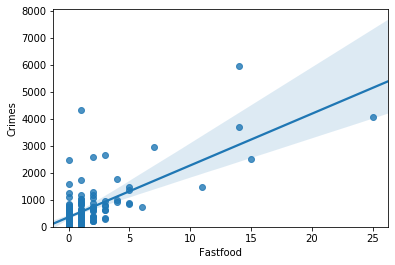

In [55]:
sns.regplot(x="Fastfood", y="Crimes", data=df_incidents_grouped)
plt.ylim(0,)

<b>P-value</b>: 
<p>What is this P-value? The P-value is the probability value that the correlation between these two variables is statistically significant. Normally, we choose a significance level of 0.05, which means that we are 95% confident that the correlation between the variables is significant.</p>

By convention, when the
<ul>
    <li>p-value is $<$ 0.001: we say there is strong evidence that the correlation is significant.</li>
    <li>the p-value is $<$ 0.05: there is moderate evidence that the correlation is significant.</li>
    <li>the p-value is $<$ 0.1: there is weak evidence that the correlation is significant.</li>
    <li>the p-value is $>$ 0.1: there is no evidence that the correlation is significant.</li>
</ul>

In [56]:
from scipy import stats
pearson_coef, p_value = stats.pearsonr(df_sums['Fastfood'], df_sums['Crimes'])
print("The Pearson Correlation Coefficient between Fastfood venues presence and Crimes is", pearson_coef, " with a P-value of P =", p_value) 
pearson_coef, p_value = stats.pearsonr(df_sums['Yoga'], df_sums['Crimes'])
print("The Pearson Correlation Coefficient between Yoga venues presence and Crimes is", pearson_coef, " with a P-value of P =", p_value)  
pearson_coef, p_value = stats.pearsonr(df_sums['Income'], df_sums['Crimes'])
print("The Pearson Correlation Coefficient between Average Income per Household and Crimes is", pearson_coef, " with a P-value of P =", p_value)  

The Pearson Correlation Coefficient between Fastfood venues presence and Crimes is 0.7085020108512083  with a P-value of P = 6.970930586185497e-31
The Pearson Correlation Coefficient between Yoga venues presence and Crimes is 0.4864399942517627  with a P-value of P = 6.436520775576165e-13
The Pearson Correlation Coefficient between Average Income per Household and Crimes is -0.15836724300092672  with a P-value of P = 0.027420251750343953


**Conclusion**:
Since the p-value is  <  0.001, the correlation between the presence of fast-food ventures and criminality within the same neighborhood is statistically significant, and the linear relationship is quite strong (~0.708, close to 1)

Our analysis shows surprising results for those data under those vintages for the city of San Francisco. Our tongue-in-cheek assumption happened to be verified, **there is a solid correlation between the density of fast-food ventures in an area and criminality level**. This is a correlation, not a causation.

More interesting is the fact that for San Francisco, applied to the census blocks the **Average Income per Household shows no obvious inverse correlation**. Criminality looks completely unrelated. This is very surprising as this was our gauging index.

Also the presence of **yoga studios shows a very mild correlation with criminality**. This is a plain proof for a **wrong assumption** showing that certainly population density is a stronger factor than population type in the business plan to establish those shops.

## Conclusion <a name="conclusion"></a>

While we found something odd about the city of San Francisco, we could only conclude that this city is not typical. Which is certainly why it is the subject of many studies.

Back to our goals:

Primary

*   **For a short span of time, if both economic and societal profile of San Francisco does not change as well as most Fast Food chain business model remains consistent, a high concentration of those could translate in a potentially more dangerous area**. But this is a second hand indicator and could be only valid at the time of the study.

Secondary

*   Shouldering the idea that information is not data but what we get out of it.
This is the way we decided to work our data. Our data sources are not absolutely leading in any case to those solutions. A different type of shop used, a different approach or territorial partition would provide **different information with the same data sets**.

*   The difference between correlation and causation in action. Are happy meals coming with concealed firearms? No.

*   Working with nonoptimal/indirectly correlated data for a case, as most real-life projects. Our results could be absolutely biased because we chose to work on non optimal data. Far from the origin of our problem. **Not crossing information in that case can't lead to an actual firm conclusion but at most data oddities and peculiar data or mathematical facts**.

*   Showing the importance of ethics and a way fake news could be born. The most important conclusion in the end is that ethics are the key factor in data analysis. People believe in the power of data, report and images based on official reports and datasets labelled ".gov" but it is surprisingly easy to cherry pick what conveniently concurs to what we want to say, true or not. **From data selection, cleaning, parsing, methods to interpretation, there are so many ways of stamping a fake/inaccurate information as legit**.